# iBKH-based Knowledge Discovery - A Case Study for Drug Repurposing Hypothesis Generation for Alzheimer's Disease

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import requests
import os

def download_box_folder(folder_id, shared_name, output_dir='./'):
    base_url = 'https://wcm.app.box.com/index.php'
    payload = {
        'folder_id': folder_id,
        'q[shared_item][shared_name]': shared_name,
        'rm': 'box_v2_zip_shared_folder'
    }
    response = requests.get(base_url, params=payload)

    if response.status_code == 200:
        print("Download started")
        download_url = response.json()['download_url']
        download_path = os.path.join(output_dir, 'Data.zip')
        os.system(f'wget "{download_url}" -O {download_path}')
        os.system(f'unzip {download_path} -d {output_dir}')
        print('Download and extraction successful!')
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")


download_box_folder('165383398725', 'jbh90entaed2jotvyab8wjsrprs4i5i8', output_dir='./')

download_box_folder('136736736585', 'gagu6yj2toyk4kirb6hpsb1qu4dm203p', output_dir='./')

download_box_folder('136737329030', 'dcq6lj4vxzs4rnxu6xx60ziwl62qrzyp', output_dir='./')

Download started
Download and extraction successful!
Download started
Download and extraction successful!
Download started
Download and extraction successful!


In [2]:
os.mkdir('/content/Data/iBKH')

In [5]:
import shutil

def move_folder(source, destination):
    try:
        shutil.move(source, destination)
        print(f"Folder moved successfully from {source} to {destination}")
    except Exception as e:
        print(f"Error: {e}")

source_folder = '/content/relation'
destination_folder = '/content/Data/iBKH'

move_folder(source_folder, destination_folder)


source_folder = '/content/entity'
destination_folder = '/content/Data/iBKH'

move_folder(source_folder, destination_folder)

Folder moved successfully from /content/relation to /content/Data/iBKH
Folder moved successfully from /content/entity to /content/Data/iBKH


In [3]:
import pandas as pd
import numpy as np

import torch as th
import torch.nn.functional as fn

from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt

### Step 1:  Generate Triplet Set from iBKH

In [4]:
import os
kg_folder = '/content/Data/iBKH/'
triplet_path = '/content/Data/triplets/'
if not os.path.exists(triplet_path):
    os.makedirs(triplet_path)

In [5]:
def DDi_triplets():
    ddi = pd.read_csv(kg_folder + 'relation/D_Di_res.csv')

    ddi_treats = ddi[ddi['Treats'] == 1]
    ddi_treats['Relation'] = ['Treats_DDi'] * len(ddi_treats)
    ddi_treats = ddi_treats[['Drug', 'Relation', 'Disease', 'Inference_Score']]

    ddi_palliates = ddi[ddi['Palliates'] == 1]
    ddi_palliates['Relation'] = ['Palliates_DDi'] * len(ddi_palliates)
    ddi_palliates = ddi_palliates[['Drug', 'Relation', 'Disease', 'Inference_Score']]

    ddi_effect = ddi[ddi['Effect'] == 1]
    ddi_effect['Relation'] = ['Effect_DDi'] * len(ddi_effect)
    ddi_effect = ddi_effect[['Drug', 'Relation', 'Disease', 'Inference_Score']]

    ddi_associate = ddi[ddi['Associate'] == 1]
    ddi_associate['Relation'] = ['Associate_DDi'] * len(ddi_associate)
    ddi_associate = ddi_associate[['Drug', 'Relation', 'Disease', 'Inference_Score']]

    ddi_IR = ddi[ddi['Inferred_Relation'] == 1]
    ddi_IR['Relation'] = ['Inferred_Relation_DDi'] * len(ddi_IR)
    ddi_IR = ddi_IR[['Drug', 'Relation', 'Disease', 'Inference_Score']]

    ddi_SR = ddi[
        (ddi['treatment/therapy (including investigatory)'] == 1) | (ddi['inhibits cell growth (esp. cancers)'] == 1) |
        (ddi['alleviates, reduces'] == 1) | (ddi['biomarkers (of disease progression)'] == 1) |
        (ddi['prevents, suppresses'] == 1) | (ddi['role in disease pathogenesis'] == 1)]
    ddi_SR['Relation'] = ['Semantic_Relation_DDi'] * len(ddi_SR)
    ddi_SR = ddi_SR[['Drug', 'Relation', 'Disease', 'Inference_Score']]

    ddi_res = pd.concat((ddi_treats, ddi_palliates, ddi_effect, ddi_associate, ddi_IR, ddi_SR))
    ddi_res = ddi_res.rename(columns={'Drug': 'Head', 'Disease': 'Tail'})

    ddi_res.loc[ddi_res['Relation'] != 'Inferred_Relation_DDi', 'Inference_Score'] = np.nan

    ddi_res.to_csv('Data/triplets/DDi_triplet.csv', index=False)

In [6]:
def DG_triplets():
    dg = pd.read_csv(kg_folder + 'relation/D_G_res.csv')

    dg_target = dg[dg['Target'] == 1]
    dg_target['Relation'] = ['Target_DG'] * len(dg_target)
    dg_target['Inference_Score'] = [''] * len(dg_target)
    dg_target = dg_target[['Drug', 'Relation', 'Gene', 'Inference_Score']]

    dg_transporter = dg[dg['Transporter'] == 1]
    dg_transporter['Relation'] = ['Transporter_DG'] * len(dg_transporter)
    dg_transporter['Inference_Score'] = [''] * len(dg_transporter)
    dg_transporter = dg_transporter[['Drug', 'Relation', 'Gene', 'Inference_Score']]

    dg_enzyme = dg[dg['Enzyme'] == 1]
    dg_enzyme['Relation'] = ['Enzyme_DG'] * len(dg_enzyme)
    dg_enzyme['Inference_Score'] = [''] * len(dg_enzyme)
    dg_enzyme = dg_enzyme[['Drug', 'Relation', 'Gene', 'Inference_Score']]

    dg_carrier = dg[dg['Carrier'] == 1]
    dg_carrier['Relation'] = ['Carrier_DG'] * len(dg_carrier)
    dg_carrier['Inference_Score'] = [''] * len(dg_carrier)
    dg_carrier = dg_carrier[['Drug', 'Relation', 'Gene', 'Inference_Score']]

    dg_downregulates = dg[dg['Downregulates'] == 1]
    dg_downregulates['Relation'] = ['Downregulates_DG'] * len(dg_downregulates)
    dg_downregulates['Inference_Score'] = [''] * len(dg_downregulates)
    dg_downregulates = dg_downregulates[['Drug', 'Relation', 'Gene', 'Inference_Score']]

    dg_upregulates = dg[dg['Upregulates'] == 1]
    dg_upregulates['Relation'] = ['Upregulates_DG'] * len(dg_upregulates)
    dg_upregulates['Inference_Score'] = [''] * len(dg_upregulates)
    dg_upregulates = dg_downregulates[['Drug', 'Relation', 'Gene', 'Inference_Score']]

    dg_associate = dg[dg['Associate'] == 1]
    dg_associate['Relation'] = ['Associate_DG'] * len(dg_associate)
    dg_associate['Inference_Score'] = [''] * len(dg_associate)
    dg_associate = dg_associate[['Drug', 'Relation', 'Gene', 'Inference_Score']]

    dg_binds = dg[dg['Binds'] == 1]
    dg_binds['Relation'] = ['Binds_DG'] * len(dg_binds)
    dg_binds['Inference_Score'] = [''] * len(dg_binds)
    dg_binds = dg_binds[['Drug', 'Relation', 'Gene', 'Inference_Score']]

    dg_interaction = dg[dg['Interaction'] == 1]
    dg_interaction['Relation'] = ['Interaction_DG'] * len(dg_interaction)
    dg_interaction['Inference_Score'] = [''] * len(dg_interaction)
    dg_interaction = dg_interaction[['Drug', 'Relation', 'Gene', 'Inference_Score']]

    dg_SR = dg[(dg['affects expression/production (neutral)'] == 1) | (dg['agonism, activation'] == 1) |
               (dg['inhibits'] == 1) | (dg['metabolism, pharmacokinetics'] == 1) | (dg['antagonism, blocking'] == 1) |
               (dg['increases expression/production'] == 1) | (dg['binding, ligand (esp. receptors)'] == 1) |
               (dg['decreases expression/production'] == 1) | (dg['transport, channels'] == 1) |
               (dg['enzyme activity'] == 1) | (dg['physical association'] == 1)]
    dg_SR['Relation'] = ['Semantic_Relation_DG'] * len(dg_SR)
    dg_SR['Inference_Score'] = [''] * len(dg_SR)
    dg_SR = dg_SR[['Drug', 'Relation', 'Gene', 'Inference_Score']]

    dg_res = pd.concat(
        (dg_target, dg_transporter, dg_enzyme, dg_carrier, dg_downregulates, dg_upregulates, dg_associate,
         dg_binds, dg_interaction, dg_SR))
    dg_res = dg_res.rename(columns={'Drug': 'Head', 'Gene': 'Tail'})

    dg_res.to_csv('Data/triplets/DG_triplet.csv', index=False)

In [7]:
def DiG_triplets():
    dig = pd.read_csv(kg_folder + 'relation/Di_G_res.csv')

    dig_associate = dig[dig['Associate'] == 1]
    dig_associate['Relation'] = ['Associate_DiG'] * len(dig_associate)
    dig_associate = dig_associate[['Disease', 'Relation', 'Gene', 'Inference_Score']]

    dig_downregulates = dig[dig['Downregulates'] == 1]
    dig_downregulates['Relation'] = ['Downregulates_DiG'] * len(dig_downregulates)
    dig_downregulates = dig_downregulates[['Disease', 'Relation', 'Gene', 'Inference_Score']]

    dig_upregulates = dig[dig['Upregulates'] == 1]
    dig_upregulates['Relation'] = ['Upregulates_DiG'] * len(dig_upregulates)
    dig_upregulates = dig_upregulates[['Disease', 'Relation', 'Gene', 'Inference_Score']]

    dig_IR = dig[dig['Inferred_Relation'] == 1]
    dig_IR['Relation'] = ['Inferred_Relation_DiG'] * len(dig_IR)
    dig_IR = dig_IR[['Disease', 'Relation', 'Gene', 'Inference_Score']]

    dig_SR = dig[(dig['improper regulation linked to disease'] == 1) | (dig['causal mutations'] == 1) |
                 (dig['polymorphisms alter risk'] == 1) | (dig['role in pathogenesis'] == 1) |
                 (dig['possible therapeutic effect'] == 1) | (dig['biomarkers (diagnostic)'] == 1) |
                 (dig['promotes progression'] == 1) | (dig['drug targets'] == 1) | (
                         dig['overexpression in disease'] == 1) |
                 (dig['mutations affecting disease course'] == 1)]
    dig_SR['Relation'] = ['Semantic_Relation_DiG'] * len(dig_SR)
    dig_SR = dig_SR[['Disease', 'Relation', 'Gene', 'Inference_Score']]

    dig_res = pd.concat((dig_associate, dig_downregulates, dig_upregulates, dig_IR, dig_SR))
    dig_res = dig_res.rename(columns={'Disease': 'Head', 'Gene': 'Tail'})

    dig_res.loc[dig_res['Relation'] != 'Inferred_Relation_DiG', 'Inference_Score'] = np.nan

    dig_res.to_csv('Data/triplets/DiG_triplet.csv', index=False)

In [8]:
def GG_triplets():
    gg = pd.read_csv(kg_folder + 'relation/G_G_res.csv')

    gg_covaries = gg[gg['Covaries'] == 1]
    gg_covaries['Relation'] = ['Covaries_GG'] * len(gg_covaries)
    gg_covaries['Inference_Score'] = [''] * len(gg_covaries)
    gg_covaries = gg_covaries[['Gene_1', 'Relation', 'Gene_2', 'Inference_Score']]

    gg_interacts = gg[gg['Interacts'] == 1]
    gg_interacts['Relation'] = ['Interacts_GG'] * len(gg_interacts)
    gg_interacts['Inference_Score'] = [''] * len(gg_interacts)
    gg_interacts = gg_interacts[['Gene_1', 'Relation', 'Gene_2', 'Inference_Score']]

    gg_regulates = gg[gg['Regulates'] == 1]
    gg_regulates['Relation'] = ['Regulates_GG'] * len(gg_regulates)
    gg_regulates['Inference_Score'] = [''] * len(gg_regulates)
    gg_regulates = gg_regulates[['Gene_1', 'Relation', 'Gene_2', 'Inference_Score']]

    gg_associate = gg[gg['Associate'] == 1]
    gg_associate['Relation'] = ['Associate_GG'] * len(gg_associate)
    gg_associate['Inference_Score'] = [''] * len(gg_associate)
    gg_associate = gg_associate[['Gene_1', 'Relation', 'Gene_2', 'Inference_Score']]

    gg_SR = gg[
        (gg['activates, stimulates'] == 1) | (gg['production by cell population'] == 1) | (gg['regulation'] == 1) |
        (gg['binding, ligand (esp. receptors)'] == 1) | (gg['signaling pathway'] == 1) |
        (gg['increases expression/production'] == 1) | (gg['same protein or complex'] == 1) |
        (gg['enhances response'] == 1) | (gg['affects expression/production (neutral)'] == 1) |
        (gg['physical association'] == 1) | (gg['association'] == 1) | (gg['colocalization'] == 1) |
        (gg['dephosphorylation reaction'] == 1) | (gg['cleavage reaction'] == 1) | (gg['direct interation'] == 1) |
        (gg['ADP ribosylation reaction'] == 1) | (gg['ubiquitination reaction'] == 1) |
        (gg['phosphorylation reaction'] == 1) | (gg['protein cleavage'] == 1)]
    gg_SR['Relation'] = ['Semantic_Relation_GG'] * len(gg_SR)
    gg_SR['Inference_Score'] = [''] * len(gg_SR)
    gg_SR = gg_SR[['Gene_1', 'Relation', 'Gene_2', 'Inference_Score']]

    gg_res = pd.concat((gg_covaries, gg_interacts, gg_regulates, gg_associate, gg_SR))
    gg_res = gg_res.rename(columns={'Gene_1': 'Head', 'Gene_2': 'Tail'})

    gg_res.to_csv('Data/triplets/GG_triplet.csv', index=False)

Run functions to generate corresponding triplets

In [ ]:
DDi_triplets()
DG_triplets()
DiG_triplets()
GG_triplets()

This is an AD (Alzheimer's disease) drug repurposing task, to avoid information leaking in model training, we removed all AD-related triplets from the Drug-Disease triplet set.

In [11]:
def generate_training_set():
    disease_vocab = pd.read_csv(kg_folder + 'entity/disease_vocab.csv')
    AD_related_list = []
    for i in range(len(disease_vocab)):
        primary_id = disease_vocab.loc[i, 'primary']
        disease_name = disease_vocab.loc[i, 'name']
        disease_name = disease_name if not pd.isnull(disease_name) else ''
        if 'alzheimer' in disease_name:
            if primary_id not in AD_related_list:
                AD_related_list.append(primary_id)

    triplet_folder = 'Data/triplets/'
    DDi_triplet = pd.read_csv(triplet_folder + 'DDi_triplet.csv')
    DDi_triplet = DDi_triplet[~(DDi_triplet['Tail'].isin(AD_related_list))]
    DDi_triplet = DDi_triplet.reset_index(drop=True)
    DG_triplet = pd.read_csv(triplet_folder + 'DG_triplet.csv')
    DiG_triplet = pd.read_csv(triplet_folder + 'DiG_triplet.csv')
    GG_triplet = pd.read_csv(triplet_folder + 'GG_triplet.csv')

    triplet_set = pd.concat((DDi_triplet, DG_triplet, DiG_triplet, GG_triplet))
    triplet_set = triplet_set[['Head', 'Relation', 'Tail']]

    triplet_set.to_csv(triplet_folder + 'training_triplets.csv', index=False)

generate_training_set()

In [12]:
import numpy as np
triplet_folder = '/content/Data/triplets/'
def generate_training_set():
    triplets_set = pd.read_csv(triplet_folder + 'training_triplets.csv')

    triples = triplets_set.values.tolist()
    train_set = np.arange(len(triples)).tolist()

    dataset_path = '/cotent/Data/dataset/'
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)

    print(len(triples), len(train_set))
    with open(dataset_path + "training_triplets.tsv", 'w+') as f:
        for idx in train_set:
            f.writelines("{}\t{}\t{}\n".format(triples[idx][0], triples[idx][1], triples[idx][2]))

generate_training_set()

32558767 32558767


### Step 2:  Knowledge graph embedding based on the triplets

##### TransE

In [ ]:
!DGLBACKEND=pytorch dglke_train --dataset iBKH --data_path ./dataset --data_files training_triplets.tsv --format raw_udd_hrt --model_name TransE_l2 --batch_size 1024 --neg_sample_size 256 --hidden_dim 200 --gamma 12.0 --lr 0.1 --max_step 10000 --log_interval 100 --batch_size_eval 1000 -adv --regularization_coef 1.00E-07 --num_thread 1 --num_proc 8 --neg_sample_size_eval 1000

##### TransR

In [ ]:
!DGLBACKEND=pytorch dglke_train --dataset iBKH --data_path ./dataset --data_files training_triplets.tsv --format raw_udd_hrt --model_name TransR --batch_size 1024 --neg_sample_size 256 --hidden_dim 200 --gamma 12.0 --lr 0.005 --max_step 10000 --log_interval 100 --batch_size_eval 1000 -adv --regularization_coef 1.00E-07 --num_thread 1 --num_proc 8 --neg_sample_size_eval 1000

##### DistMult

In [ ]:
!DGLBACKEND=pytorch dglke_train --dataset iBKH --data_path ./dataset --data_files training_triplets.tsv --format raw_udd_hrt --model_name DistMult --batch_size 1024 --neg_sample_size 256 --hidden_dim 400 --gamma 12.0 --lr 0.005 --max_step 10000 --log_interval 100 --batch_size_eval 1000 -adv --regularization_coef 1.00E-07 --num_thread 1 --num_proc 8 --neg_sample_size_eval 1000

##### ComplEx

In [ ]:
!DGLBACKEND=pytorch dglke_train --dataset iBKH --data_path ./dataset --data_files training_triplets.tsv --format raw_udd_hrt --model_name ComplEx --batch_size 1024 --neg_sample_size 256 --hidden_dim 200 --gamma 12.0 --lr 0.05 --max_step 10000 --log_interval 100 --batch_size_eval 1000 -adv --regularization_coef 1.00E-07 --num_thread 1 --num_proc 8 --neg_sample_size_eval 1000

### Step 3: Link prediction for AD drug repurposing hypothesis generation

In [4]:
def transE_l2(head, rel, tail, gamma=12.0):
    score = head + rel - tail

    return gamma - th.norm(score, p=2, dim=-1)

In [5]:
def transR(head, rel, tail, proj, rel_idx, gamma=12.0):
    proj = proj.reshape(-1, head.shape[1], rel.shape[0])[rel_idx]
    head_r = th.einsum('ab,bc->ac', head, proj)
    tail_r = th.einsum('b,bc->c', th.tensor(tail), proj)
    score = head_r + rel - tail_r

    return gamma - th.norm(score, p=1, dim=-1)

In [6]:
def DistMult(head, rel, tail):
    score = head * rel * tail

    return th.sum(score, dim=-1)

In [7]:
def complEx(head, rel, tail, gamma=12.0):
    real_head, img_head = th.chunk(head, 2, dim=-1)
    real_tail, img_tail = th.chunk(th.tensor(tail), 2, dim=-1)
    real_rel, img_rel = th.chunk(rel, 2, dim=-1)

    score = real_head * real_tail * real_rel \
            + img_head * img_tail * real_rel \
            + real_head * img_tail * img_rel \
            - img_head * real_tail * img_rel

    return th.sum(score, -1)

Below we define the AD_drugs_possibility_prediction function, which generates a prediction score for each drug, indicating the probablity that the drug can be used to treat AD.

In [8]:
os.mkdir('/content/drive/MyDrive/GA/Data/predict_result')
os.mkdir('/content/drive/MyDrive/GA/Data/predict_result/roc_figures')

In [9]:
folder = '/content/drive/MyDrive/GA/Data/'
Drug_list_folder = '/content/drive/MyDrive/GA/Data/Drug_list/'
kg_folder = '/content/drive/MyDrive/GA/Data/iBKH/'
result_folder = '/content/drive/MyDrive/GA/Data/predict_result/'

In [10]:
def AD_drugs_possibility_prediction(model_name, trial_status):
    entity_df = pd.read_table(folder + model_name + '/entities.tsv', header=None)
    entity_df = entity_df.dropna().reset_index(drop=True)
    approved_drug_df = pd.read_csv(Drug_list_folder + 'drugs_list_' + trial_status + '.csv')
    approved_drug_list = list(approved_drug_df['Drug'])

    entity_map = {}
    entity_id_map = {}
    relation_map = {}
    drug_ids = []
    drug_names = []
    disease_ids = []

    for i in range(len(entity_df)):
        entity_id = entity_df.loc[i, 0]
        entity_name = entity_df.loc[i, 1]
        entity_map[entity_name] = int(entity_id)
        entity_id_map[int(entity_id)] = entity_name
        if entity_name.replace('DrugBank:', '') in approved_drug_list:
            drug_ids.append(entity_id)
            drug_names.append(entity_name.replace('DrugBank:', ''))

    disease_vocab = pd.read_csv(kg_folder + 'entity/disease_vocab.csv')
    AD_related_list = []
    for i in range(len(disease_vocab)):
        primary_id = disease_vocab.loc[i, 'primary']
        disease_name = disease_vocab.loc[i, 'name']
        disease_name = disease_name if not pd.isnull(disease_name) else ''
        if 'alzheimer' in disease_name:
            if primary_id not in AD_related_list:
                AD_related_list.append(primary_id)

    relation_df = pd.read_table(folder + model_name + '/relations.tsv', header=None)
    for i in range(len(relation_df)):
        relation_id = relation_df.loc[i, 0]
        relation_name = relation_df.loc[i, 1]
        relation_map[relation_name] = int(relation_id)

    for disease in AD_related_list:
        if disease in entity_map:
            disease_ids.append(entity_map[disease])

    entity_emb = np.load(folder + model_name + '/iBKH_' + model_name + '_entity.npy')
    rel_emb = np.load(folder + model_name + '/iBKH_' + model_name + '_relation.npy')
    if model_name == 'TransR':
        proj_np = np.load(folder + 'TransR/iBKH_TransRprojection.npy')
        proj_emb = th.tensor(proj_np)

    treatment = ['Treats_DDi', 'Palliates_DDi', 'Effect_DDi', 'Associate_DDi', 'Inferred_Relation_DDi',
                 'Semantic_Relation_DDi']
    treatment_rid = [relation_map[treat] for treat in treatment]

    drug_ids = th.tensor(drug_ids).long()
    disease_ids = th.tensor(disease_ids).long()
    treatment_rid = th.tensor(treatment_rid)

    drug_emb = th.tensor(entity_emb[drug_ids])
    treatment_embs = [th.tensor(rel_emb[rid]) for rid in treatment_rid]

    scores_per_disease = []
    dids = []
    for rid in range(len(treatment_embs)):
        treatment_emb = treatment_embs[rid]
        for disease_id in disease_ids:
            disease_emb = th.tensor(entity_emb[disease_id])
            if model_name == 'RotatE':
                score = fn.logsigmoid(rotatE(drug_emb, treatment_emb, disease_emb))
            elif model_name == 'ComplEx':
                score = fn.logsigmoid(complEx(drug_emb, treatment_emb, disease_emb))
            elif model_name == 'TransR':
                score = fn.logsigmoid(transR(drug_emb, treatment_emb, disease_emb, proj_emb, treatment_rid[rid]))
            elif model_name == 'TransE_l2':
                score = fn.logsigmoid(transE_l2(drug_emb, treatment_emb, disease_emb))
            elif model_name == 'DistMult':
                score = fn.logsigmoid(DistMult(drug_emb, treatment_emb, disease_emb))
            scores_per_disease.append(score)
            dids.append(drug_ids)
    scores = th.cat(scores_per_disease)
    dids = th.cat(dids)

    idx = th.flip(th.argsort(scores), dims=[0])
    scores = scores[idx].numpy()
    dids = dids[idx].numpy()

    _, unique_indices = np.unique(dids, return_index=True)
    topk_indices = np.sort(unique_indices)
    proposed_dids = dids[topk_indices]
    proposed_scores = scores[topk_indices]

    candidate_drug_rank = []
    candidate_drug_score = {}
    for i, idx in enumerate(proposed_dids):
        candidate_drug_rank.append(entity_id_map[int(idx)].replace('DrugBank:', ''))
        candidate_drug_score[entity_id_map[int(idx)].replace('DrugBank:', '')] = proposed_scores[i]

    df = pd.DataFrame(columns=['Drug', 'Score'])
    idx = 0
    for drug in candidate_drug_score:
        df.loc[idx] = [drug, candidate_drug_score[drug]]
        idx += 1

    x = np.asarray(df['Score']).reshape(-1, 1)  # returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df['Score_scaled'] = pd.DataFrame(x_scaled)
    print(df)
    df.to_csv(result_folder + "predict_result_scaled_" + model_name + "_" + trial_status + ".csv", index=False)

We propose an ensemble model, which combines the results based on TransE, TransR, DistMult, and complEx to claculate a combined score for each drug.

In [11]:
def ensemble_model(trial_status):
    transE_res = pd.read_csv(result_folder + "predict_result_scaled_TransE_l2_" + trial_status + ".csv")['Drug'].tolist()
    transR_res = pd.read_csv(result_folder + "predict_result_scaled_TransR_" + trial_status + ".csv")['Drug'].tolist()
    complEx_res = pd.read_csv(result_folder + "predict_result_scaled_ComplEx_" + trial_status + ".csv")['Drug'].tolist()
    distMult_res = pd.read_csv(result_folder + "predict_result_scaled_DistMult_" + trial_status + ".csv")['Drug'].tolist()

    res = pd.DataFrame(columns=['Drug', 'vote_score'])
    idx = 0
    for drug in transE_res:
        vote_transE = len(transE_res) - transE_res.index(drug)
        vote_transR = len(transR_res) - transR_res.index(drug)
        vote_complEx = len(complEx_res) - complEx_res.index(drug)
        vote_distMult = len(distMult_res) - distMult_res.index(drug)
        vote_score = vote_transE + vote_transR + vote_complEx + vote_distMult
        res.loc[idx] = [drug, vote_score]
        idx += 1
    res = res.sort_values('vote_score', ascending=False)
    res = res.reset_index(drop=True)
    x = np.asarray(res['vote_score']).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    res['Score_scaled'] = pd.DataFrame(x_scaled)
    print(res)
    res.to_csv(result_folder + "predict_result_scaled_ensemble_" + trial_status + ".csv", index=False)

#### Model Evaluatoin

In [39]:
def generate_AUC(model_name):
    figures_folder = result_folder + 'roc_figures/'
    drug_trial_list = ['approve_phase1234', 'approve_phase234', 'approve_phase34', 'approve_phase4', 'approve']
    trial_info = {'approve_phase1234': {'label': 'FDA approved+Phase I~IV', 'color': '#6a4c93'},
                  'approve_phase234': {'label': 'FDA approved+Phase II~IV', 'color': '#1982c4'},
                  'approve_phase34': {'label': 'FDA approved+Phase III,IV', 'color': '#8ac926'},
                  'approve_phase4': {'label': 'FDA approved+Phase IV', 'color': '#ffca3a'},
                  'approve': {'label': 'FDA approved', 'color': '#ff595e'}}
    plt.figure(figsize=(7, 7))

    for trial_status in drug_trial_list:
        predict_res = pd.read_csv(result_folder + "predict_result_scaled_" + model_name + "_" + trial_status + ".csv")
        candidate_df = pd.read_csv(Drug_list_folder + 'drugs_list_' + trial_status + '.csv')

        df = pd.merge(predict_res, candidate_df, on='Drug')

        label = np.array(list(df['label']))
        score = np.array(list(df['Score_scaled']))
        # score = np.array(list(df['Score']))

        fpr, tpr, thresholds = metrics.roc_curve(label, score)
        youden = tpr - fpr
        youden_J = np.max(youden)
        inds_youden_J = np.where(youden == youden_J)
        tpr_max = tpr[inds_youden_J]
        fpr_max = fpr[inds_youden_J]
        cut_off = thresholds[inds_youden_J][0]
        sensitivity = tpr_max[0]
        specificity = 1 - fpr_max[0]
        prevalence = np.where(label == 1)[0].shape[0] / label.shape[0]
        acc = (sensitivity * prevalence) + (specificity * (1 - prevalence))
        print(cut_off, sensitivity, specificity, acc)
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=trial_info[trial_status]['label'] + ', AUC=' + str(round(auc, 2)),
                 color=trial_info[trial_status]['color'])

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=.8)
    plt.tick_params(labelsize=16, bottom=True, left=True)
    plt.xlabel("1 - Specificity", fontsize=12, fontweight='bold')
    plt.ylabel("Sensitivity", fontsize=12, fontweight='bold')
    plt.grid(alpha=.3)
    plt.legend(prop={'size': 12}, loc=4)
    plt.title(model_name, fontweight='bold', fontsize=18)
    plt.show()
    plt.savefig(figures_folder + model_name + '.pdf', dpi=300)
    plt.close()

In [13]:
drug_trial_list = [
    'approve_phase1234', # FDA Approved AD drugs + AD drugs in clinical trials Phase I, II, III and IV.
    'approve_phase234',  # FDA Approved AD drugs + AD drugs in clinical trials Phase II, III and IV.
    'approve_phase34',   # FDA Approved AD drugs + AD drugs in clinical trials Phase III and IV.
    'approve_phase4',    # FDA Approved AD drugs + AD drugs in clinical trials Phase IV.
    'approve'            # FDA Approved AD drugs only.
]

##### Prediction & ROC curve (TransE)

         Drug     Score  Score_scaled
0     DB00524 -0.065711      1.000000
1     DB00787 -0.091514      0.986623
2     DB00518 -0.092911      0.985899
3     DB00571 -0.095223      0.984700
4     DB00582 -0.095701      0.984452
...       ...       ...           ...
2828  DB12288 -1.862142      0.068688
2829  DB11341 -1.872925      0.063098
2830  DB12035 -1.932656      0.032132
2831  DB03808 -1.990675      0.002053
2832  DB09351 -1.994636      0.000000

[2833 rows x 3 columns]
         Drug     Score  Score_scaled
0     DB00524 -0.065711      1.000000
1     DB00787 -0.091514      0.986623
2     DB00518 -0.092911      0.985899
3     DB00571 -0.095223      0.984700
4     DB00582 -0.095701      0.984452
...       ...       ...           ...
2821  DB12288 -1.862142      0.068688
2822  DB11341 -1.872925      0.063098
2823  DB12035 -1.932656      0.032132
2824  DB03808 -1.990675      0.002053
2825  DB09351 -1.994636      0.000000

[2826 rows x 3 columns]
         Drug     Score  Score_scaled


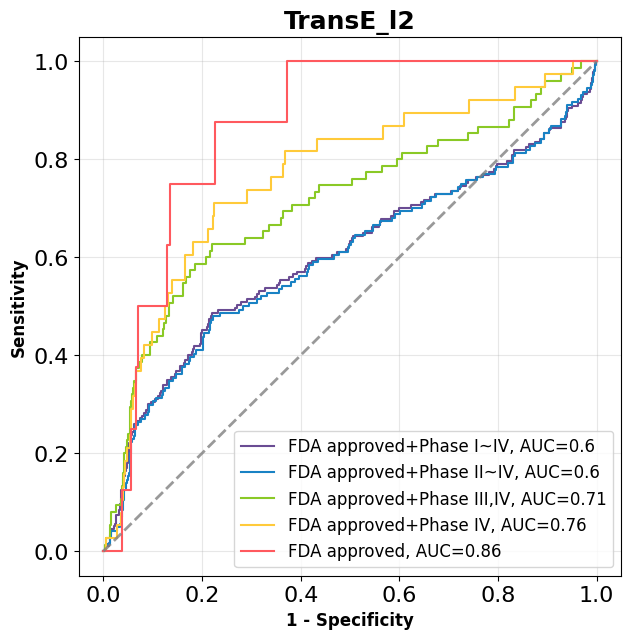

In [40]:
model_name = 'TransE_l2'
for trial_status in drug_trial_list:
    AD_drugs_possibility_prediction(model_name, trial_status)

generate_AUC(model_name)

##### Prediction & ROC curve (TransR)

<ipython-input-5-45d94f82a3d5>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tail_r = th.einsum('b,bc->c', th.tensor(tail), proj)


         Drug      Score  Score_scaled
0     DB09140  -0.009543      1.000000
1     DB00537  -0.009863      0.999985
2     DB00563  -0.011667      0.999902
3     DB00254  -0.011989      0.999887
4     DB00207  -0.012431      0.999866
...       ...        ...           ...
2828  DB09105 -15.223799      0.295527
2829  DB11059 -15.313053      0.291394
2830  DB14895 -15.734541      0.271878
2831  DB09513 -16.687788      0.227739
2832  DB11131 -21.606190      0.000000

[2833 rows x 3 columns]


<ipython-input-5-45d94f82a3d5>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tail_r = th.einsum('b,bc->c', th.tensor(tail), proj)


         Drug      Score  Score_scaled
0     DB09140  -0.009543      1.000000
1     DB00537  -0.009863      0.999985
2     DB00563  -0.011667      0.999902
3     DB00254  -0.011989      0.999887
4     DB00207  -0.012431      0.999866
...       ...        ...           ...
2821  DB09105 -15.223799      0.295527
2822  DB11059 -15.313053      0.291394
2823  DB14895 -15.734541      0.271878
2824  DB09513 -16.687788      0.227739
2825  DB11131 -21.606190      0.000000

[2826 rows x 3 columns]


<ipython-input-5-45d94f82a3d5>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tail_r = th.einsum('b,bc->c', th.tensor(tail), proj)


         Drug      Score  Score_scaled
0     DB09140  -0.009543      1.000000
1     DB00537  -0.009863      0.999985
2     DB00563  -0.011667      0.999902
3     DB00254  -0.011989      0.999887
4     DB00207  -0.012431      0.999866
...       ...        ...           ...
2789  DB09105 -15.223799      0.295527
2790  DB11059 -15.313053      0.291394
2791  DB14895 -15.734541      0.271878
2792  DB09513 -16.687788      0.227739
2793  DB11131 -21.606190      0.000000

[2794 rows x 3 columns]


<ipython-input-5-45d94f82a3d5>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tail_r = th.einsum('b,bc->c', th.tensor(tail), proj)


         Drug      Score  Score_scaled
0     DB09140  -0.009543      1.000000
1     DB00537  -0.009863      0.999985
2     DB00563  -0.011667      0.999902
3     DB00254  -0.011989      0.999887
4     DB00207  -0.012431      0.999866
...       ...        ...           ...
2782  DB09105 -15.223799      0.295527
2783  DB11059 -15.313053      0.291394
2784  DB14895 -15.734541      0.271878
2785  DB09513 -16.687788      0.227739
2786  DB11131 -21.606190      0.000000

[2787 rows x 3 columns]


<ipython-input-5-45d94f82a3d5>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tail_r = th.einsum('b,bc->c', th.tensor(tail), proj)


         Drug      Score  Score_scaled
0     DB09140  -0.009543      1.000000
1     DB00537  -0.009863      0.999985
2     DB00563  -0.011667      0.999902
3     DB00254  -0.011989      0.999887
4     DB00207  -0.012431      0.999866
...       ...        ...           ...
2782  DB09105 -15.223799      0.295527
2783  DB11059 -15.313053      0.291394
2784  DB14895 -15.734541      0.271878
2785  DB09513 -16.687788      0.227739
2786  DB11131 -21.606190      0.000000

[2787 rows x 3 columns]
0.9924214 0.559322033898305 0.7078313253012047 0.6985527709142252
0.9924214 0.5486111111111112 0.703206562266965 0.6953290870488323
0.9924214 0.68 0.6987863184994483 0.6982820329277022
0.9910588 0.8421052631578947 0.6456893415787559 0.648367420165052
0.9924214 1.0 0.6898164807484707 0.6907068532472193


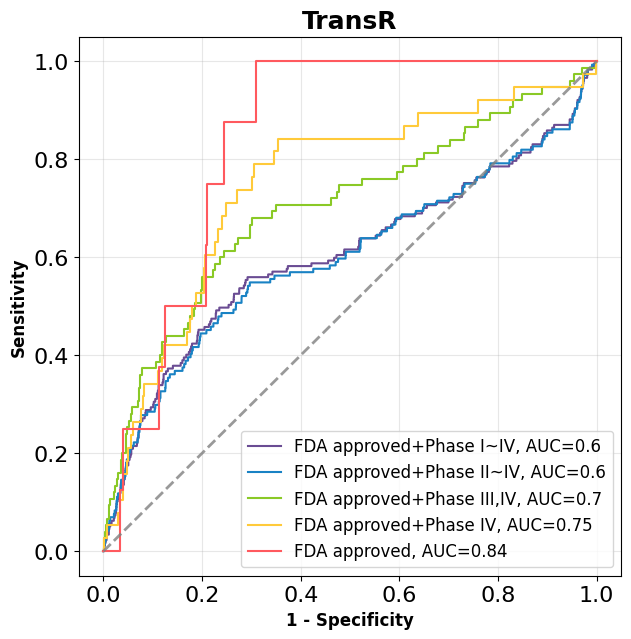

In [41]:
model_name = 'TransR'
for trial_status in drug_trial_list:
    AD_drugs_possibility_prediction(model_name, trial_status)

generate_AUC(model_name)

##### Prediction & ROC curve (DistMult)

         Drug     Score  Score_scaled
0     DB00481 -0.372688      1.000000
1     DB01024 -0.381678      0.927835
2     DB00715 -0.384056      0.908744
3     DB00570 -0.384390      0.906059
4     DB00445 -0.385554      0.896722
...       ...       ...           ...
2828  DB11160 -0.487333      0.079709
2829  DB06148 -0.488829      0.067700
2830  DB04813 -0.490058      0.057838
2831  DB09320 -0.494103      0.025362
2832  DB14761 -0.497263      0.000000

[2833 rows x 3 columns]
         Drug     Score  Score_scaled
0     DB00481 -0.372688      1.000000
1     DB01024 -0.381678      0.927835
2     DB00715 -0.384056      0.908744
3     DB00570 -0.384390      0.906059
4     DB00445 -0.385554      0.896722
...       ...       ...           ...
2821  DB11160 -0.487333      0.079709
2822  DB06148 -0.488829      0.067700
2823  DB04813 -0.490058      0.057838
2824  DB09320 -0.494103      0.025362
2825  DB14761 -0.497263      0.000000

[2826 rows x 3 columns]
         Drug     Score  Score_scaled


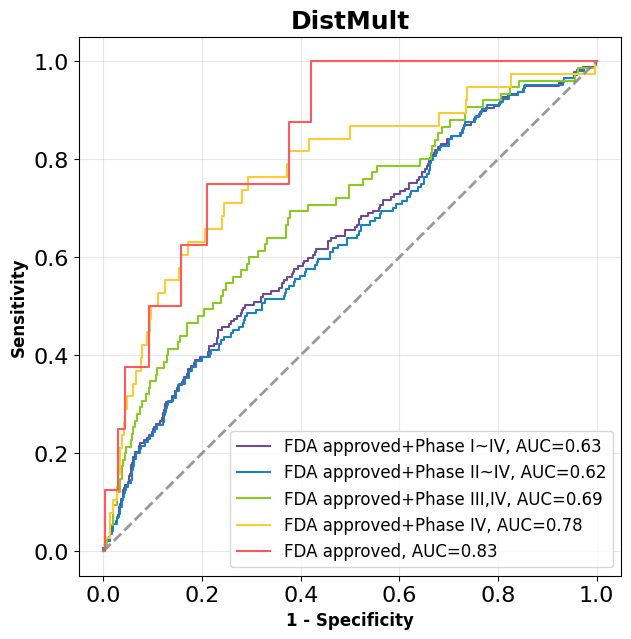

In [42]:
model_name = 'DistMult'
for trial_status in drug_trial_list:
    AD_drugs_possibility_prediction(model_name, trial_status)

generate_AUC(model_name)

##### Prediction & ROC curve (ComplEx)

<ipython-input-7-378e1214d89c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_tail, img_tail = th.chunk(th.tensor(tail), 2, dim=-1)


         Drug     Score  Score_scaled
0     DB03128 -0.104596      1.000000
1     DB14177 -0.132959      0.967921
2     DB14084 -0.136602      0.963800
3     DB01080 -0.149151      0.949607
4     DB11387 -0.153008      0.945245
...       ...       ...           ...
2828  DB09106 -0.960000      0.032522
2829  DB11932 -0.961163      0.031206
2830  DB13967 -0.962479      0.029718
2831  DB11065 -0.965912      0.025836
2832  DB15982 -0.988755      0.000000

[2833 rows x 3 columns]


<ipython-input-7-378e1214d89c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_tail, img_tail = th.chunk(th.tensor(tail), 2, dim=-1)


         Drug     Score  Score_scaled
0     DB03128 -0.104596      1.000000
1     DB14177 -0.132959      0.967921
2     DB14084 -0.136602      0.963800
3     DB01080 -0.149151      0.949607
4     DB11387 -0.153008      0.945245
...       ...       ...           ...
2821  DB09106 -0.960000      0.032522
2822  DB11932 -0.961163      0.031206
2823  DB13967 -0.962479      0.029718
2824  DB11065 -0.965912      0.025836
2825  DB15982 -0.988755      0.000000

[2826 rows x 3 columns]


<ipython-input-7-378e1214d89c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_tail, img_tail = th.chunk(th.tensor(tail), 2, dim=-1)


         Drug     Score  Score_scaled
0     DB03128 -0.104596      1.000000
1     DB14177 -0.132959      0.967921
2     DB14084 -0.136602      0.963800
3     DB01080 -0.149151      0.949607
4     DB11387 -0.153008      0.945245
...       ...       ...           ...
2789  DB09106 -0.960000      0.032522
2790  DB11932 -0.961163      0.031206
2791  DB13967 -0.962479      0.029718
2792  DB11065 -0.965912      0.025836
2793  DB15982 -0.988755      0.000000

[2794 rows x 3 columns]


<ipython-input-7-378e1214d89c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_tail, img_tail = th.chunk(th.tensor(tail), 2, dim=-1)


         Drug     Score  Score_scaled
0     DB03128 -0.104596      1.000000
1     DB14177 -0.132959      0.967921
2     DB14084 -0.136602      0.963800
3     DB01080 -0.149151      0.949607
4     DB11387 -0.153008      0.945245
...       ...       ...           ...
2782  DB09106 -0.960000      0.032522
2783  DB11932 -0.961163      0.031206
2784  DB13967 -0.962479      0.029718
2785  DB11065 -0.965912      0.025836
2786  DB15982 -0.988755      0.000000

[2787 rows x 3 columns]


<ipython-input-7-378e1214d89c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_tail, img_tail = th.chunk(th.tensor(tail), 2, dim=-1)


         Drug     Score  Score_scaled
0     DB03128 -0.104596      1.000000
1     DB14177 -0.132959      0.967921
2     DB14084 -0.136602      0.963800
3     DB01080 -0.149151      0.949607
4     DB11387 -0.153008      0.945245
...       ...       ...           ...
2782  DB09106 -0.960000      0.032522
2783  DB11932 -0.961163      0.031206
2784  DB13967 -0.962479      0.029718
2785  DB11065 -0.965912      0.025836
2786  DB15982 -0.988755      0.000000

[2787 rows x 3 columns]
0.8183987 0.4293785310734463 0.7880271084337349 0.7656194846452524
0.8183987 0.4027777777777778 0.7833706189410887 0.7639773531493277
0.80216813 0.6266666666666667 0.7035674880470761 0.7015032211882606
0.80216813 0.7894736842105263 0.700618406693343 0.7018299246501614
0.81160915 1.0 0.7423533645196114 0.7430929314675279


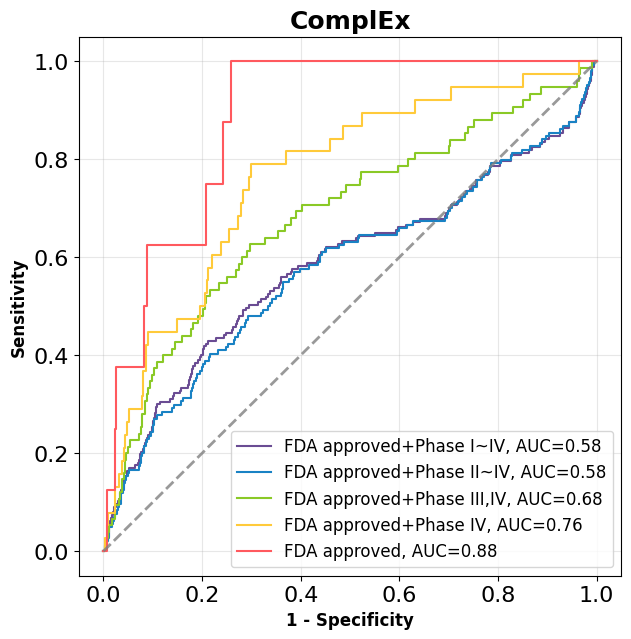

In [43]:
model_name = 'ComplEx'
for trial_status in drug_trial_list:
    AD_drugs_possibility_prediction(model_name, trial_status)

generate_AUC(model_name)

##### Prediction & ROC curve (Ensemble Model)

         Drug  vote_score  Score_scaled
0     DB00635       11203      1.000000
1     DB00741       11103      0.990756
2     DB00661       11080      0.988630
3     DB01115       11062      0.986966
4     DB00537       11031      0.984101
...       ...         ...           ...
2828  DB13140         501      0.010723
2829  DB15906         485      0.009244
2830  DB09484         439      0.004992
2831  DB14632         426      0.003790
2832  DB06137         385      0.000000

[2833 rows x 3 columns]
         Drug  vote_score  Score_scaled
0     DB00635       11175      1.000000
1     DB00741       11075      0.990738
2     DB00661       11052      0.988608
3     DB01115       11034      0.986941
4     DB00537       11003      0.984070
...       ...         ...           ...
2821  DB13140         495      0.010836
2822  DB15906         478      0.009262
2823  DB09484         432      0.005001
2824  DB14632         423      0.004168
2825  DB06137         378      0.000000

[2826 rows x 3

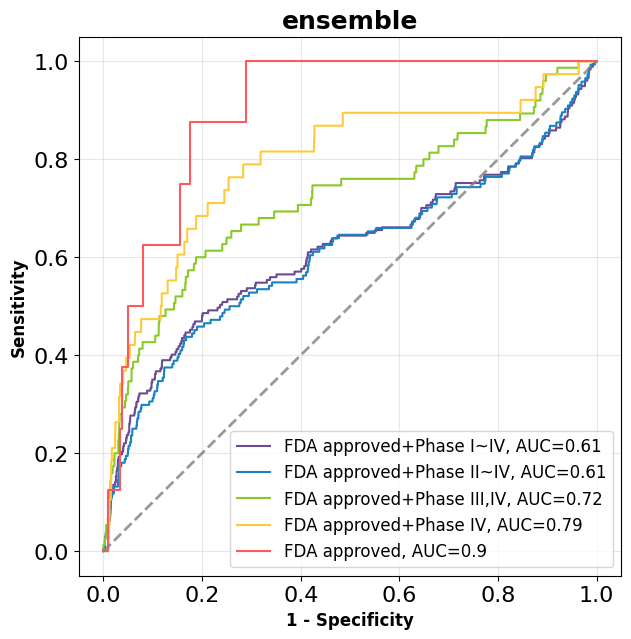

In [44]:
for trial_status in drug_trial_list:
    ensemble_model(trial_status)

generate_AUC('ensemble')

# Step 4: Covid-19

In [19]:
COV_disease_list = [
'Disease::SARS-CoV2 E',
'Disease::SARS-CoV2 M',
'Disease::SARS-CoV2 N',
'Disease::SARS-CoV2 Spike',
'Disease::SARS-CoV2 nsp1',
'Disease::SARS-CoV2 nsp10',
'Disease::SARS-CoV2 nsp11',
'Disease::SARS-CoV2 nsp12',
'Disease::SARS-CoV2 nsp13',
'Disease::SARS-CoV2 nsp14',
'Disease::SARS-CoV2 nsp15',
'Disease::SARS-CoV2 nsp2',
'Disease::SARS-CoV2 nsp4',
'Disease::SARS-CoV2 nsp5',
'Disease::SARS-CoV2 nsp5_C145A',
'Disease::SARS-CoV2 nsp6',
'Disease::SARS-CoV2 nsp7',
'Disease::SARS-CoV2 nsp8',
'Disease::SARS-CoV2 nsp9',
'Disease::SARS-CoV2 orf10',
'Disease::SARS-CoV2 orf3a',
'Disease::SARS-CoV2 orf3b',
'Disease::SARS-CoV2 orf6',
'Disease::SARS-CoV2 orf7a',
'Disease::SARS-CoV2 orf8',
'Disease::SARS-CoV2 orf9b',
'Disease::SARS-CoV2 orf9c',
'Disease::MESH:D045169',
'Disease::MESH:D045473',
'Disease::MESH:D001351',
'Disease::MESH:D065207',
'Disease::MESH:D028941',
'Disease::MESH:D058957',
'Disease::MESH:D006517'
]

In [20]:
import csv

drug_list = []
with open("/content/drive/MyDrive/GA/Data/utils/infer_drug.tsv", newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['drug','ids'])
    for row_val in reader:
        drug_list.append(row_val['drug'])

In [21]:
len(drug_list)

8104

In [22]:
treatment = ['Hetionet::CtD::Compound:Disease','GNBR::T::Compound:Disease']

In [27]:
entity_idmap_file = '/content/drive/MyDrive/GA/Data/utils/embed/entities.tsv'
relation_idmap_file = '/content/drive/MyDrive/GA/Data/utils/embed/relations.tsv'

In [28]:
entity_map = {}
entity_id_map = {}
relation_map = {}
with open(entity_idmap_file, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['name','id'])
    for row_val in reader:
        entity_map[row_val['name']] = int(row_val['id'])
        entity_id_map[int(row_val['id'])] = row_val['name']

with open(relation_idmap_file, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['name','id'])
    for row_val in reader:
        relation_map[row_val['name']] = int(row_val['id'])

drug_ids = []
disease_ids = []
for drug in drug_list:
    drug_ids.append(entity_map[drug])

for disease in COV_disease_list:
    disease_ids.append(entity_map[disease])

treatment_rid = [relation_map[treat]  for treat in treatment]

In [29]:
import torch as th
entity_emb = np.load('/content/drive/MyDrive/GA/Data/utils/embed/DRKG_TransE_l2_entity.npy')
rel_emb = np.load('/content/drive/MyDrive/GA/Data/utils/embed/DRKG_TransE_l2_relation.npy')

drug_ids = th.tensor(drug_ids).long()
disease_ids = th.tensor(disease_ids).long()
treatment_rid = th.tensor(treatment_rid)

drug_emb = th.tensor(entity_emb[drug_ids])
treatment_embs = [th.tensor(rel_emb[rid]) for rid in treatment_rid]

In [30]:
import torch.nn.functional as fn

gamma=12.0
def transE_l2(head, rel, tail):
    score = head + rel - tail
    return gamma - th.norm(score, p=2, dim=-1)

scores_per_disease = []
dids = []
for rid in range(len(treatment_embs)):
    treatment_emb=treatment_embs[rid]
    for disease_id in disease_ids:
        disease_emb = entity_emb[disease_id]
        score = fn.logsigmoid(transE_l2(drug_emb, treatment_emb, disease_emb))
        scores_per_disease.append(score)
        dids.append(drug_ids)
scores = th.cat(scores_per_disease)
dids = th.cat(dids)

In [31]:
idx = th.flip(th.argsort(scores), dims=[0])
scores = scores[idx].numpy()
dids = dids[idx].numpy()

In [32]:
_, unique_indices = np.unique(dids, return_index=True)
topk=100
topk_indices = np.sort(unique_indices)[:topk]
proposed_dids = dids[topk_indices]
proposed_scores = scores[topk_indices]

In [33]:
for i in range(topk):
    drug = int(proposed_dids[i])
    score = proposed_scores[i]

    print("{}\t{}".format(entity_id_map[drug], score))

Compound::DB00811	-0.21416780352592468
Compound::DB00993	-0.8350887298583984
Compound::DB00635	-0.8974790573120117
Compound::DB01082	-0.985488772392273
Compound::DB01234	-0.9984012842178345
Compound::DB00982	-1.0160716772079468
Compound::DB00563	-1.0189464092254639
Compound::DB00290	-1.0641062259674072
Compound::DB01394	-1.080676555633545
Compound::DB01222	-1.084547519683838
Compound::DB00415	-1.0853973627090454
Compound::DB01004	-1.096669316291809
Compound::DB00860	-1.1004788875579834
Compound::DB00681	-1.1011555194854736
Compound::DB00688	-1.1256868839263916
Compound::DB00624	-1.1428292989730835
Compound::DB00959	-1.1618409156799316
Compound::DB00115	-1.186812400817871
Compound::DB00091	-1.1906721591949463
Compound::DB01024	-1.2051165103912354
Compound::DB00741	-1.2147064208984375
Compound::DB00441	-1.2320411205291748
Compound::DB00158	-1.2346546649932861
Compound::DB00499	-1.252516746520996
Compound::DB00929	-1.2730495929718018
Compound::DB00770	-1.282552719116211
Compound::DB01331	

In [34]:
clinical_drugs_file = '/content/drive/MyDrive/GA/Data/utils/COVID19_clinical_trial_drugs.tsv'
clinical_drug_map = {}
with open(clinical_drugs_file, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['id', 'drug_name','drug_id'])
    for row_val in reader:
        clinical_drug_map[row_val['drug_id']] = row_val['drug_name']

for i in range(topk):
    drug = entity_id_map[int(proposed_dids[i])][10:17]
    if clinical_drug_map.get(drug, None) is not None:
        score = proposed_scores[i]
        print("[{}]\t{}\t{}".format(i, clinical_drug_map[drug],score , proposed_scores[i]))

[0]	Ribavirin	-0.21416780352592468
[4]	Dexamethasone	-0.9984012842178345
[8]	Colchicine	-1.080676555633545
[16]	Methylprednisolone	-1.1618409156799316
[49]	Oseltamivir	-1.3885042667388916
[87]	Deferoxamine	-1.5130668878555298
